In [1]:
import pandas as pd
import os
import numpy as np
import json
import seaborn as sns
import matplotlib as plt
from datetime import datetime
from zoneinfo import ZoneInfo
import zoneinfo
from functools import lru_cache
import ics
import icalendar
from icalendar import Calendar, Event, vCalAddress, vText
from pathlib import Path
import pytz

In [2]:
with open('opendatabcn_agenda.json') as json_file:
    data = json.load(json_file)

df = pd.DataFrame(data)

In [3]:
df.head()

,register_id,prefix,suffix,name,created,modified,status,status_name,core_type,core_type_name,...,end_date,estimated_dates,languages_data,type,type_name,period,period_name,event_status_name,event_status,ical
0,96144110517,None,None,Horari d'il.luminacions Anella Olímpica,1993-04-27T00:00:00+02:00,2022-09-17T05:21:50.026220+02:00,published,Publicat,event,Agenda,...,None,None,"[{'id': 1, 'language': 'Indiferent'}]",permanent,Permanent,NaN,,Correcte,ok,BEGIN:VCALENDAR\r\nPRODID:ics.py - http://git....
1,96207130634,None,None,Campanya de capta per la Sagrada Família,1993-02-22T00:00:00+01:00,2022-09-17T05:22:26.760483+02:00,published,Publicat,event,Agenda,...,None,None,"[{'id': 1, 'language': 'Indiferent'}]",permanent,Permanent,NaN,,Correcte,ok,BEGIN:VCALENDAR\r\nPRODID:ics.py - http://git....
2,97063140243,None,None,Anys de traspàs,1997-03-04T00:00:00+01:00,2022-09-17T05:28:48.932403+02:00,published,Publicat,event,Agenda,...,None,None,"[{'id': 1, 'language': 'Indiferent'}]",permanent,Permanent,NaN,,Correcte,ok,BEGIN:VCALENDAR\r\nPRODID:ics.py - http://git....
3,1302161826,"""Festa Major de les Roquetes""",None,Dates de Festa Major,2001-10-29T00:00:00+01:00,2023-04-28T11:31:10.712603+02:00,published,Publicat,event,Agenda,...,2023-06-18T03:00:00+02:00,None,"[{'id': 1, 'language': 'Indiferent'}]",repetitive,Cíclic,1.0,anual,Correcte,ok,BEGIN:VCALENDAR\r\nPRODID:ics.py - http://git....
4,1302171519,None,None,Festa Major de Vallbona: Dates,2001-10-29T00:00:00+01:00,2023-04-27T10:44:36.254167+02:00,published,Publicat,event,Agenda,...,2023-07-16T03:00:00+02:00,None,"[{'id': 1, 'language': 'Indiferent'}]",repetitive,Cíclic,1.0,anual,Correcte,ok,BEGIN:VCALENDAR\r\nPRODID:ics.py - http://git....


DROP COLUMNS AND ROWS THAT ARE USELESS FOR THE DATASET

In [4]:
df = df.drop(['suffix', 'status', 'status_name', 'values', 'from_relationships', 'to_relationships'], axis=1)
df = df.drop(df[df['core_type_name'] == 'Equipament'].index)
df = df.drop(['core_type', 'core_type_name', 
              'body', 'entity_types_data', 
              'attribute_categories', 'classifications_data', 
             'secondary_filters_data', 'timetable', 
             'image_data', 'warnings', 'is_section_of_data', 'sections_data',
             'type_name', 'period', 'gallery_data'], axis=1)
df = df.drop(df[df['event_status'] == 'suspended'].index)
df = df.drop(df[df['event_status'] == 'deferred'].index)
df = df.drop(['event_status_name', 'event_status', 'ical', 'estimated_dates'], axis=1)
df = df.drop(['geo_epgs_25831', 'geo_epgs_23031'], axis=1)


Those rows that do not have a starting day, will be replace by the 'create' date

In [5]:
df['start_date'] = df['start_date'].fillna(0)
df['start_date'] = np.where(df['start_date'] == 0, df['created'], df['start_date'])

I will drop the events that are permanent because they do not have a significant impact in the frequency of riding bikes in Barcelona

In [6]:
df = df.drop(['created', 'modified'], axis=1)
df = df.drop(df[df['type'] == 'permanent'].index)

1. DEFINE EXACT LOCATIONS

In [7]:
# Extract the values from the 'nested_df_column'
geo_location = df['geo_epgs_4326'].apply(pd.Series)
# Concatenate the new value columns with the main DataFrame
df = pd.concat([df, geo_location], axis=1)
# Drop the original column containing nested DataFrames if desired
df.drop('geo_epgs_4326', axis=1, inplace=True)

/var/folders/87/kjpchb1d2w7fgc99b9md3q300000gn/T/ipykernel_17054/922827287.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  geo_location = df['geo_epgs_4326'].apply(pd.Series)
/var/folders/87/kjpchb1d2w7fgc99b9md3q300000gn/T/ipykernel_17054/922827287.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  geo_location = df['geo_epgs_4326'].apply(pd.Series)
/var/folders/87/kjpchb1d2w7fgc99b9md3q300000gn/T/ipykernel_17054/922827287.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  geo_location = df['geo_epgs_4326'].apply(pd.Series)
/var/folders/87/kjpchb1d2w7fgc99b9md3q300000gn/T/ipykernel_17054/922827287.py:2: FutureWarning: The default dtyp

In [8]:
extracted_values = df['addresses'].apply(pd.Series)
extracted_extracted_values = extracted_values[0].apply(pd.Series)
extracted_extracted_values = extracted_extracted_values.loc[:, ['district_name',
                                                               'district_id',
                                                               'neighborhood_name',
                                                               'neighborhood_id',
                                                               'address_name',
                                                               'address_id',
                                                               'zip_code']]
df = pd.concat([df, extracted_extracted_values], axis=1)
df.drop('addresses', axis=1, inplace=True)

In [9]:
df['x'] = df['x'].fillna(0)
df['y'] = df['y'].fillna(0)
print(len(df[df['x'] == 0]))
print(len(df[df['y'] == 0]))

#Let's plot the location without the outliers
df_nan_values = df[df['x']!=0]
df_nan_values = df_nan_values[df_nan_values['x']> 30]
df_nan_values = df_nan_values[df_nan_values['y']!=0]
df_nan_values = df_nan_values[df_nan_values['y']> 1]

96
96


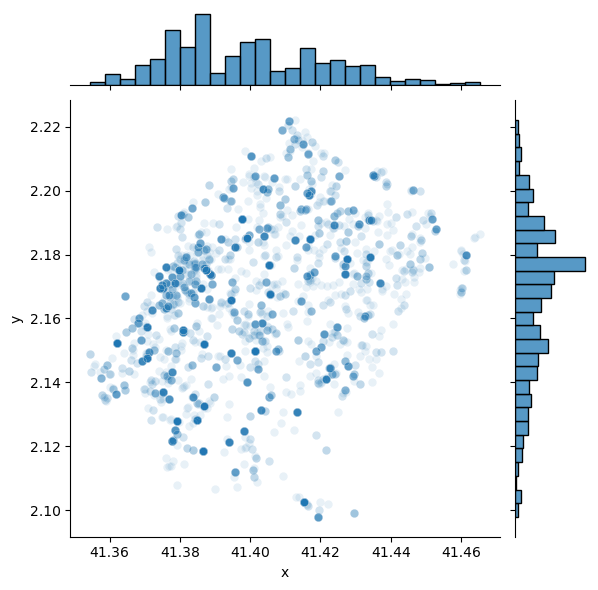

In [10]:
sns.jointplot(x="x", y="y", data= df_nan_values, alpha=0.1)

There are some rows whose coordinates are NaN values. Moreover, there are other rows that have an incorrect location. These rows are going to be substituted by the median of the coordinates of the city.

In [11]:
df['x'] = np.where(df['x'] < 30, 0, df['x'])
df['y'] = np.where(df['y'] < 1, 0, df['y'])
print(len(df[df['x'] == 0]))
print(len(df[df['y'] == 0]))

109
109


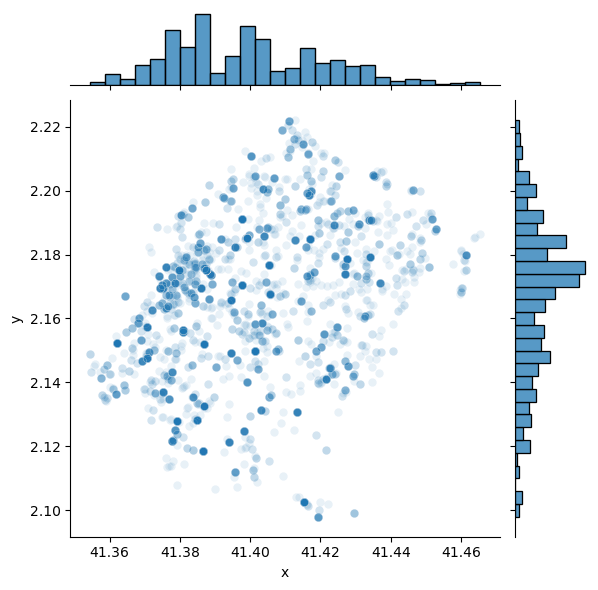

In [12]:
median_location_x = df_nan_values['x'].median()
median_location_y = df_nan_values['y'].median()
df['x'] = np.where(df['x'] == 0, median_location_x, df['x'])
df['y'] = np.where(df['y'] == 0, median_location_y, df['y'])
sns.jointplot(x="x", y="y", data= df, alpha=0.1)

Still there are some row whose district and neighbourhoods are unknown:

In [13]:
df['district_name'] = df['district_name'].fillna('Unknown')
df['neighborhood_name'] = df['neighborhood_name'].fillna('Unknown')

Let's do the following with the unknown names:
1. Obtain the average and the standard deviation of the geolocation of each district and neighbourhood.
2. If one row has a geolocation and that is within the errors of the previous grouping strategy, add the name of the corresponding district and neighbourhood

In [14]:
df['district_mean'] = df.groupby('district_name')['x'].transform('mean')
df['district_std'] = df.groupby('district_name')['x'].transform('std')

DEFINE DATE TIME

In [15]:
def get_timezones():
    return zoneinfo.available_timezones()
datetime.strptime('2022-02-18T00:00:00.000Z', '%Y-%m-%dT%H:%M:%S.%f%z').astimezone(ZoneInfo('Europe/Madrid')).strftime('%Y-%m-%d')

#datetime.strptime('2023-06-12T03:00:00+02:00', '%Y-%m-%dT%H:%M:%S+%f:%z').astimezone(ZoneInfo('Europe/Madrid')).strftime('%Y-%m-%d')


'2022-02-18'

<AxesSubplot:xlabel='month'>

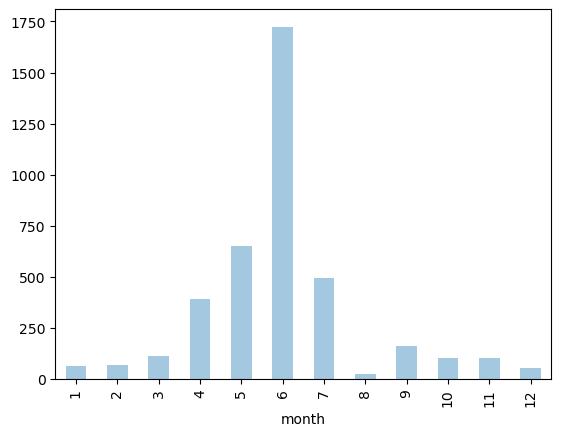

In [16]:
# Convert the column to datetime data type
df['start_date'] = pd.to_datetime(df['start_date'], utc=True)
df['end_date'] = pd.to_datetime(df['start_date'], utc=True)

df['day'] = df['start_date'].dt.day
df['month'] = df['start_date'].dt.month
df['year'] = df['start_date'].dt.year

df['end_day'] = df['end_date'].dt.day
df['end_month'] = df['end_date'].dt.month

df_monthly_frequency = df[['month']].groupby('month').size()
df_monthly_frequency.plot(kind='bar',style='b', alpha=0.4)

#df['duration'] = df['end_date'] - df['start_date']
#df['duration'].value_counts()
#df['duration'] = df['duration'].dt.day

In [17]:
print(df['year'].value_counts())
df = df.drop(df[df['year'] == 2013].index)
df = df.drop(df[df['year'] == 2026].index)
df = df.drop(df[df['year'] == 2024].index)
print(df['year'].value_counts())

2023    3603
2022     169
2024     165
2021       8
2020       3
2019       2
2013       1
2026       1
Name: year, dtype: int64
2023    3603
2022     169
2021       8
2020       3
2019       2
Name: year, dtype: int64


I can see that most of the events start in June, that is the starting month of summer for children. I want to know if this kind of event belongs to children or teenager. If that is the case, I have to erase these rows because they are not allowed to take the public bikes in Barcelona

In [18]:
df_vacances_estiu = df[df['prefix'] == 'Campanya Vacances Estiu 2023']
print(df_vacances_estiu.shape)
mask_infants = df_vacances_estiu['name'].str.contains('infants|adolescents')
count_infants = mask_infants.sum()
print(count_infants)

(812, 25)
809


In [19]:
print(df.shape)
df['infants_true'] = df['name'].str.contains('infants|adolescents')
df = df.drop(df[df['infants_true'] == True].index)
df = df.drop(['infants_true'], axis=1)
print(df.shape)

(3785, 25)
(2937, 25)


<AxesSubplot:xlabel='month'>

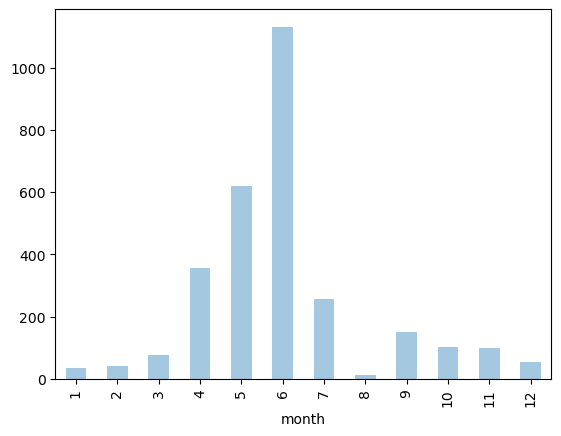

In [20]:
df_monthly_frequency = df[['month']].groupby('month').size()
df_monthly_frequency.plot(kind='bar',style='b', alpha=0.4)

THE TICKETS AND THE LANGUAGE

In [21]:
tickets = df['tickets_data'].apply(pd.Series)
tickets_0 = tickets[0].apply(pd.Series)
tickets_0 = tickets_0.drop([0], axis=1)
tickets_0 = tickets_0.rename(columns={"id": 'tickets_id', "name": 'tickets_name'})
# Concatenate the new value columns with the main DataFrame
df = pd.concat([df, tickets_0], axis=1)
df = df.drop(['tickets_data'], axis=1)

/var/folders/87/kjpchb1d2w7fgc99b9md3q300000gn/T/ipykernel_17054/4014689730.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  tickets = df['tickets_data'].apply(pd.Series)


In [22]:
lan = df['languages_data'].apply(pd.Series)
lan_0 = lan[0].apply(pd.Series)
lan_0 = lan_0.drop([0], axis=1)
lan_0 = lan_0.rename(columns={"id": 'languages_id', "name": 'languages_name'})
# Concatenate the new value columns with the main DataFrame
df = pd.concat([df, lan_0], axis=1)
df = df.drop(['languages_data'], axis=1)

/var/folders/87/kjpchb1d2w7fgc99b9md3q300000gn/T/ipykernel_17054/2923923181.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lan = df['languages_data'].apply(pd.Series)


In [23]:
df.head()

,register_id,prefix,name,start_date,end_date,type,period_name,x,y,district_name,...,district_std,day,month,year,end_day,end_month,tickets_id,tickets_name,languages_id,language
3,1302161826,"""Festa Major de les Roquetes""",Dates de Festa Major,2023-06-12 01:00:00+00:00,2023-06-12 01:00:00+00:00,repetitive,anual,41.448198,2.175879,Nou Barris,...,0.011573,12,6,2023,12,6,3.0,Lliure,1.0,Indiferent
4,1302171519,None,Festa Major de Vallbona: Dates,2023-07-14 01:00:00+00:00,2023-07-14 01:00:00+00:00,repetitive,anual,41.465511,2.186348,Nou Barris,...,0.011573,14,7,2023,14,7,3.0,Lliure,1.0,Indiferent
5,1303125645,None,Festa Major de Torre Baró: Dates,2023-06-30 01:00:00+00:00,2023-06-30 01:00:00+00:00,repetitive,anual,41.457685,2.176930,Nou Barris,...,0.011573,30,6,2023,30,6,3.0,Lliure,1.0,Indiferent
8,99400222158,None,'Sónar 2023' Festival de Música Avançada i New...,2023-06-14 22:00:00+00:00,2023-06-14 22:00:00+00:00,repetitive,anual,41.372718,2.150211,Sants-Montjuïc,...,0.005966,14,6,2023,14,6,4.0,Pagament,1.0,Indiferent
11,99400226324,"""L'Ou com Balla 2023. Corpus""","""L'Ou com Balla"" al Jardí de l'Ateneu Barcelonès",2023-06-08 01:00:00+00:00,2023-06-08 01:00:00+00:00,repetitive,anual,41.384680,2.171665,Ciutat Vella,...,0.004304,8,6,2023,8,6,3.0,Lliure,1.0,Indiferent


If the ticket price is unknown, set Lliure

In [24]:
def unknown_values(column_name, new_name):
    df[column_name] = df[column_name].fillna(0)
    df[column_name] = np.where(df[column_name] == 0, new_name, df[column_name])
    print('Types after substituting unknown values:')
    print(df[column_name].value_counts())
    print(df[column_name].isnull().sum())
    return


In [25]:
unknown_values('tickets_name', 'Lliure')

Types after substituting unknown values:
Lliure           1708
Pagament         1226
Reservada           2
Amb invitació       1
Name: tickets_name, dtype: int64
0


If the language is unknown, set as indiferent

In [26]:
unknown_values('language', 'Indiferent')

Types after substituting unknown values:
Indiferent    2635
Català         162
Castellà       115
Anglès          20
Francès          2
Altres           2
Italià           1
Name: language, dtype: int64
0


In [27]:
e = open('calendarifestius_en.ics', 'rb')
ecal = icalendar.Calendar.from_ical(e.read())
for component in ecal.walk():
    print(component.name)
e.close()

VCALENDAR
VTIMEZONE
DAYLIGHT
STANDARD
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT


In [28]:
# Extract relevant information
events = []
for event in ecal.walk('VEVENT'):
    event_data = {
        'Summary': event.get('summary'),
        'Start': event.get('dtstart').dt,
        'End': event.get('dtend').dt,
        # Add more properties as needed
    }
    events.append(event_data)

# Create a DataFrame from the extracted information
df_ecal = pd.DataFrame(events)

# Print the DataFrame
print(df_ecal.dtypes)

Summary    object
Start      object
End        object
dtype: object


In [29]:
df_ecal['Start'] = pd.to_datetime(df_ecal['Start'], utc=True)
df_ecal['End'] = pd.to_datetime(df_ecal['End'], utc=True)
print(df_ecal.dtypes)

Summary                 object
Start      datetime64[ns, UTC]
End        datetime64[ns, UTC]
dtype: object


In [30]:
df_ecal = df_ecal.rename(columns={"Start": 'start_date', "End": 'end_date', "Summary":"name"})

In [31]:
df_append = df.append(df_ecal)

/var/folders/87/kjpchb1d2w7fgc99b9md3q300000gn/T/ipykernel_17054/2222255016.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_append = df.append(df_ecal)


TO DO: if an event is set in 2023 and it is an annual event, then duplicate that row for the year 2022